The metric sweeps over a range of IoU thresholds, at each point calculating an F2 Score. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.


At each threshold value t, the F2 Score value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects. The following equation is equivalent to F2 Score when β is set to 2:



A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object. The average F2 Score of a single image is then calculated as the mean of the above F2 Score values at each IoU threshold:


Lastly, the score returned by the competition metric is the mean taken over the individual average F2 Scores of each image in the test dataset.

### Steps

- 1) Assign each instance(ship) a prediction by max IOU 
        
        IOU : # of Common pixels / # of union of pixels
        
- 2) Calculate metric


### imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import shutil
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
sys.path.append("../fastai/")
from fastai.conv_learner import *

In [3]:
path = Path("../DATA/airbus-ship/")
files = list(path.iterdir())

### step 1 - classifier 

#### make predictions

In [4]:
train_all_labels = pd.read_csv(path/"classification/train_all_lbs.csv")
test_all_labels = pd.read_csv(path/"classification/test_all_lbs.csv")

In [5]:
_, val_idx = train_test_split(train_all_labels, test_size=0.1, stratify=train_all_labels.has_ship, random_state=42)
val_idx = (val_idx.index).tolist()

In [6]:
arch = resnet18
sz = 224

In [7]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

In [8]:
# cv_idxs automatically creates validation set
data = ImageClassifierData.from_csv(path, folder='train_all', bs=128, val_idxs=val_idx,
                                    csv_fname=path/'classification/train_all_lbs.csv', tfms=tfms, test_name="test_all")

In [9]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [10]:
learn.load("ckpt4")

In [11]:
preds = learn.TTA(n_aug=5, is_test=True)

In [12]:
preds[0].shape

(7, 19256, 2)

In [13]:
preds_mean = np.mean(preds[0], axis=0)

In [14]:
preds_mean_proba = np.exp(preds_mean)

In [15]:
preds_mean_labels = np.argmax(preds_mean_proba, axis=1)

#### get classification score

In [16]:
len(test_all_labels), len(data.test_ds.fnames)

(19256, 19256)

In [17]:
test_fnames = [fname.split("/")[1] for fname in data.test_ds.fnames]

In [18]:
# map test labels to predictions
gt_dicts = dict(zip(test_all_labels.ImageId, test_all_labels.has_ship))

In [19]:
gt_list = [gt_dicts[fname] for fname in test_fnames]

In [20]:
gt_array = np.array(gt_list)
preds_mean_labels

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
cls_score = np.mean(gt_array == preds_mean_labels)

In [22]:
print(f"classification accuracy : {np.round(cls_score, 3)}")

classification accuracy : 0.957


In [23]:
pos_preds = np.array(test_fnames)[preds_mean_labels == 1]

In [24]:
print(f"number of ships predicted as positive : {len(pos_preds)}")

number of ships predicted as positive : 4031


In [79]:
# accuracy of negative preds
neg_preds_mean_labels = preds_mean_labels[preds_mean_labels == 0]
neg_preds_gt_array =  gt_array[preds_mean_labels == 0]

In [82]:
# negative predictive value
NPV = np.mean(neg_preds_mean_labels == neg_preds_gt_array)

In [83]:
NPV

0.96564860426929389

### step 2 - load segmentation model

#### make predictions for has ship predicted

In [25]:
from fastai.models.unet import *
from fastai.dataset import *
from fastai.core import *

In [26]:
train_seg_lbs = pd.read_csv(path/"segmentations/train_seg_lbs.csv")

In [27]:
unique_img_ids = train_seg_lbs.ImageId.unique()
trn_fnames, val_fnames = train_test_split(unique_img_ids, test_size=0.1, random_state=42)

In [28]:
TRN_X = [f"train_all/{fname}" for fname in trn_fnames]
TRN_Y = [f"segmentations/train_masks/{fname}" for fname in trn_fnames]

VAL_X = [f"train_all/{fname}" for fname in val_fnames]
VAL_Y = [f"segmentations/train_masks/{fname}" for fname in val_fnames]

In [29]:
TEST_X = [f"test_all/{fname}" for fname in pos_preds]

In [30]:
sz = 256

class FilesEncodedDataset(BaseDataset):
    def __init__(self, fnames, fnames2, transform, path):
        self.fnames = fnames
        self.fnames2 = fnames2
        self.path = path
        super().__init__(transform)
    
    def get_sz(self): return self.transform.sz
    def get_x(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): 
        mask = cv2.imread(os.path.join(self.path, self.fnames2[i]), cv2.IMREAD_GRAYSCALE)
        mask = (mask - 30)/185
        return cv2.resize(mask, (sz, sz)).astype('float32')
        
    def get_n(self): return len(self.fnames)
    def get_c(self): return 0

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.transform.denorm(np.rollaxis(arr,1,4))

In [31]:
f = resnet18
tfms = tfms_from_model(f, sz, crop_type=CropType.NO, tfm_y=None) # imagenet stats

In [32]:
dataset = ImageData.get_ds(FilesEncodedDataset, (TRN_X, TRN_Y),
                           (VAL_X, VAL_Y),
                           tfms=tfms, test=(TEST_X, TEST_X), path = path)

In [33]:
md = ImageData(path, dataset, bs=16, num_workers=16, classes=None)

In [34]:
# load defined model# load  
def get_encoder(f, cut):
    base_model = (cut_model(f(True), cut))
    return nn.Sequential(*base_model)

def get_model(sz=128):
    """gets dynamic unet model"""
    # choose encoder
    f = resnet18
    cut, cut_lr = model_meta[f]
    cut, cut_lr

    # define encoder
    encoder = get_encoder(f, cut)

    # init model
    m = DynamicUnet(encoder, n_classes=1) # binary: ship - not ship

    # init upsample on cpu
    inp = torch.ones(1, 3, sz, sz)
    out = m(V(inp).cpu())

    # put model to gpu if desired# put mo 
    m = m.cuda(0)
    return m

In [35]:
class BCELoss2D(nn.Module):
    def __init__(self):
        super(BCELoss2D, self).__init__()
        
    def forward(self, logits, targets):
        logits = logits.squeeze(1)
        return F.binary_cross_entropy_with_logits(logits, targets)

In [36]:
class UpsampleModel():
    def __init__(self, model, cut_lr, name='upsample'):
        self.model,self.name, self.cut_lr = model, name, cut_lr

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.encoder), [self.cut_lr]))
        return lgs + [children(self.model)[1:]]

In [37]:
cut, cut_lr = model_meta[f]

In [38]:
model = get_model(sz=256)
models = UpsampleModel(model, cut_lr)

In [39]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit = BCELoss2D()
learn.metrics = []

In [40]:
learn.load("seg_ckpt2")

In [41]:
seg_preds = learn.predict(is_test=True)

In [42]:
seg_preds.shape

(4031, 1, 256, 256)

In [43]:
seg_preds_labels = (seg_preds > 0)*1 

In [44]:
seg_preds_labels = seg_preds_labels.squeeze(1)

#### plot predictions

In [45]:
def show_side_by_side(img1, img2, axes):
    axes[0].axis('off')
    axes[1].axis('off')
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)

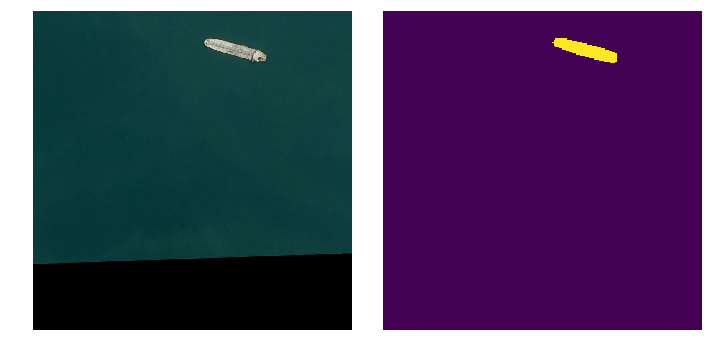

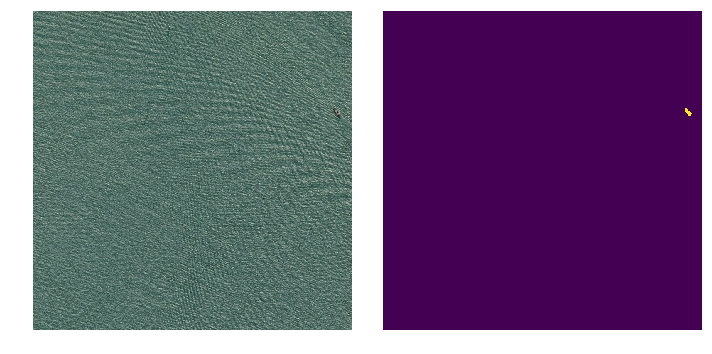

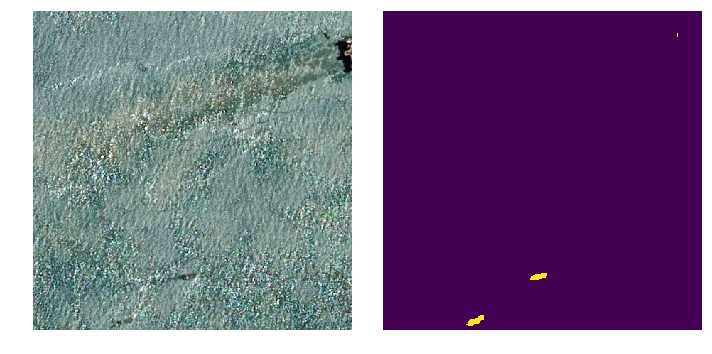

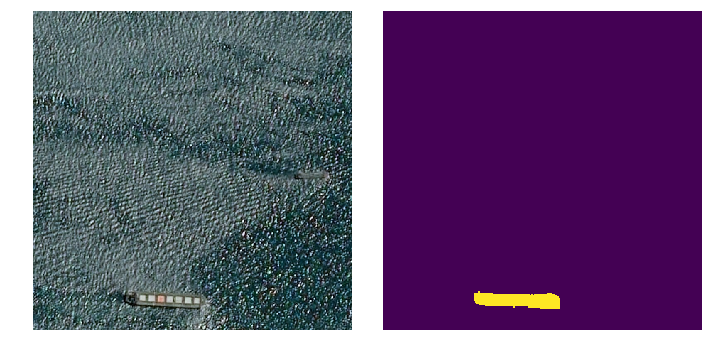

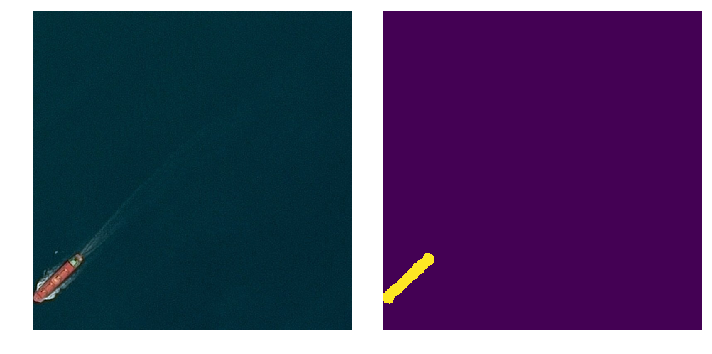

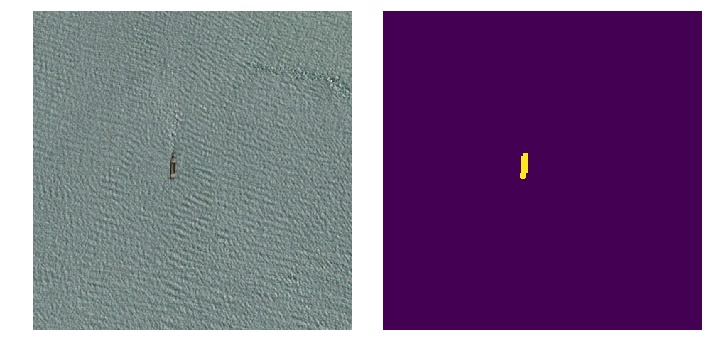

In [46]:
for i, (fname, pred) in enumerate(zip(TEST_X, seg_preds_labels)):
    img = open_image(path/fname)
    fig, axes = plt.subplots(1,2, figsize=(10, 10))
    show_side_by_side(img, pred, axes)
    if i == 5: break

#### get segmentation score

In [47]:
from skimage.measure import label

In [48]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [49]:
def get_pred_masks(labels, uniq_labels):
    """assuming all images are 768x768 originally"""
    pred_mask_arrays = []
    for l in uniq_labels[1:]:
        pred_mask = cv2.resize((labels == l).astype(np.uint8), (768, 768))
        pred_mask_arrays.append(pred_mask)
    return pred_mask_arrays

def get_gt_masks(gt_rles_i):
    """assuming all images are 768x768 originally"""
    gt_mask_arrays = []
    for gt_rle in gt_rles_i:
        gt_mask = rle_decode(gt_rle, (768, 768)) 
        gt_mask_arrays.append(gt_mask)
    return gt_mask_arrays

# Create IOU matrix preds x actual
def create_iou_matrix(pred_mask_arrays, gt_mask_arrays):
    IOU = []
    for pred_mask in pred_mask_arrays:
        for gt_mask in gt_mask_arrays:
            intersection = np.sum(pred_mask*gt_mask)
            union = np.sum((pred_mask+gt_mask)>0)
            IOU.append(intersection/union)
    # reshape
    n_preds = len(pred_mask_arrays)
    n_gt = len(gt_mask_arrays)
    IOU = np.array(IOU)
    return IOU.reshape(n_preds, n_gt)

def f2_score(tp, fp, fn):
    beta = 2
    return (1+beta**2)*tp / ((1+beta**2)*tp + (beta**2)*fn + fp)

def f2_IOU(IOU):
    """
    Calculate mean thresholded f2 score for an image and it's
    predictions.
    """
    if IOU is None:
        """no predictions is made even image has ships"""
        return 0
    else:
        """calculates metric from IOU matrix"""
        avg_f2 = 0
        for t in np.arange(0.5, 1.0, 0.05):
            IOU_at_t = (IOU > t)*1
            tp = IOU_at_t.sum()
            fp = np.sum(np.sum(IOU_at_t, axis=1) == 0)
            fn = np.sum(np.sum(IOU_at_t, axis=0) == 0)
            f2 = f2_score(tp, fp, fn)
            avg_f2 += f2
        avg_f2 /= 10
    return avg_f2

In [52]:
def get_score(pred, fname, df):
    """
    pred : np.array prediction mask
    fname : filename of the prediction as "dir/...jpg"
    df : df with rle information
    """
    gt_rles = df[df.ImageId == fname.split("/")[-1]]['EncodedPixels'].values
    labels = label(pred)
    uniq_labels = np.unique(labels)
    
    if len(uniq_labels) == 1:
        IOU = None
    else:
        pred_mask_arrays = get_pred_masks(labels, uniq_labels)
        gt_mask_arrays = get_gt_masks(gt_rles)
        IOU = create_iou_matrix(pred_mask_arrays, gt_mask_arrays)
    score = f2_IOU(IOU)
    return score

In [50]:
test_seg_lbs = pd.read_csv(path/"segmentations/test_seg_lbs.csv")

In [55]:
get_score(seg_preds_labels[0], TEST_X[0], test_seg_lbs)

0.69999999999999996

In [57]:
scores = []
for i, (pred_i, fname) in enumerate(zip(seg_preds_labels, TEST_X)):    
    score = get_score(pred_i, fname, test_seg_lbs)
    scores.append(score)

In [58]:
np.mean(scores)

0.34269787328862766

### step 3 - calculate final score

In [61]:
n_test = len(test_all_labels)

In [84]:
n_test

19256

In [62]:
n_pos_preds = len(pos_preds)

In [85]:
n_pos_preds

4031

In [86]:
n_neg_preds_ratio = 1 - (n_pos_preds/n_test)

In [87]:
n_neg_preds_ratio

0.7906626506024097

In [90]:
final_score = NPV*n_neg_preds_ratio + 0.342*(1-n_neg_preds_ratio)

In [94]:
print(f"final score: {round(final_score, 4)}")

final score: 0.8351
